In [27]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import torch
import os

In [28]:
# 設置環境變量以啟用 MPS 後備
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# 檢查 MPS 是否可用
device = (
    "mps" 
    if torch.backends.mps.is_available() 
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [29]:
# 讀取CSV文件
df = pd.read_csv('../input/training_balanced.csv')
df = df.rename(columns={'HasTransaction': 'labels'})

# 將數據分為訓練集和驗證集
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 將DataFrame轉換為Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [30]:
display(train_dataset)

Dataset({
    features: ['Content', 'labels', '__index_level_0__'],
    num_rows: 314
})

In [31]:
display(val_dataset)

Dataset({
    features: ['Content', 'labels', '__index_level_0__'],
    num_rows: 79
})

In [32]:
# 設置tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [33]:
def preprocess_function(examples):
    # 為T5添加特定的前綴
    inputs = [f"classify transaction: {text}" for text in examples["Content"]]
    # 將標籤轉換為文本格式
    targets = [str(label) for label in examples["labels"]]
    
    model_inputs = tokenizer(
        inputs, 
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    # 對標籤進行編碼
    labels = tokenizer(
        targets,
        max_length=8,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [34]:
# 對數據集應用預處理
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

In [35]:
display(tokenized_train)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 314
})

In [36]:
display(tokenized_val)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 79
})

In [37]:
# 設置基礎模型
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
).to(device)

In [66]:
# 配置LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # T5是序列到序列模型
    inference_mode=False,
    r=256,                    # 從 8 提高到 256
    lora_alpha=512,  
    lora_dropout=0.1,
    target_modules=["q", "v", "k", "o", "gate", "up", "down"]  # 增加更多目標模組
)

In [67]:
# 創建PEFT模型
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

trainable params: 56,623,104 || all params: 304,200,960 || trainable%: 18.6137


In [68]:
# 定義訓練參數
training_args = TrainingArguments(
    output_dir="../output/lora_results",
    num_train_epochs=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    auto_find_batch_size=True
)

In [69]:
# 設置Trainer並開始訓練
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

# 訓練前禁用快取以避免警告
model.config.use_cache = False

In [70]:
# 訓練模型
train_result = trainer.train()

  0%|          | 0/3900 [00:00<?, ?it/s]

{'loss': 40.1703, 'grad_norm': 50.127906799316406, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.25}
{'loss': 39.6234, 'grad_norm': 58.91666793823242, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.51}
{'loss': 39.8906, 'grad_norm': 57.35099411010742, 'learning_rate': 6.000000000000001e-07, 'epoch': 0.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 41.8125, 'eval_runtime': 4.6874, 'eval_samples_per_second': 16.854, 'eval_steps_per_second': 4.267, 'epoch': 0.99}
{'loss': 38.225, 'grad_norm': 46.25652313232422, 'learning_rate': 8.000000000000001e-07, 'epoch': 1.01}
{'loss': 39.3906, 'grad_norm': 48.9600830078125, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.27}
{'loss': 37.2797, 'grad_norm': 42.0167350769043, 'learning_rate': 1.2000000000000002e-06, 'epoch': 1.52}
{'loss': 37.7938, 'grad_norm': 55.55997848510742, 'learning_rate': 1.4000000000000001e-06, 'epoch': 1.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 39.1875, 'eval_runtime': 4.8867, 'eval_samples_per_second': 16.166, 'eval_steps_per_second': 4.093, 'epoch': 2.0}
{'loss': 37.8563, 'grad_norm': 47.93791198730469, 'learning_rate': 1.6000000000000001e-06, 'epoch': 2.03}
{'loss': 36.6516, 'grad_norm': 38.382606506347656, 'learning_rate': 1.8000000000000001e-06, 'epoch': 2.28}
{'loss': 36.4562, 'grad_norm': 34.43220520019531, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.53}
{'loss': 34.9984, 'grad_norm': 39.74566650390625, 'learning_rate': 2.2e-06, 'epoch': 2.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 35.125, 'eval_runtime': 5.1144, 'eval_samples_per_second': 15.447, 'eval_steps_per_second': 3.911, 'epoch': 2.99}
{'loss': 35.2891, 'grad_norm': 34.533748626708984, 'learning_rate': 2.4000000000000003e-06, 'epoch': 3.04}
{'loss': 33.4844, 'grad_norm': 32.64641571044922, 'learning_rate': 2.6e-06, 'epoch': 3.29}
{'loss': 32.1477, 'grad_norm': 31.420217514038086, 'learning_rate': 2.8000000000000003e-06, 'epoch': 3.54}
{'loss': 32.7336, 'grad_norm': 23.05674934387207, 'learning_rate': 3e-06, 'epoch': 3.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 30.265625, 'eval_runtime': 4.2703, 'eval_samples_per_second': 18.5, 'eval_steps_per_second': 4.683, 'epoch': 4.0}
{'loss': 30.6008, 'grad_norm': 27.903594970703125, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.05}
{'loss': 30.3453, 'grad_norm': 24.7506160736084, 'learning_rate': 3.4000000000000005e-06, 'epoch': 4.3}
{'loss': 29.2102, 'grad_norm': 26.43429946899414, 'learning_rate': 3.6000000000000003e-06, 'epoch': 4.56}
{'loss': 27.6234, 'grad_norm': 21.531475067138672, 'learning_rate': 3.8000000000000005e-06, 'epoch': 4.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 24.65625, 'eval_runtime': 4.7783, 'eval_samples_per_second': 16.533, 'eval_steps_per_second': 4.186, 'epoch': 4.99}
{'loss': 26.8133, 'grad_norm': 22.402589797973633, 'learning_rate': 4.000000000000001e-06, 'epoch': 5.06}
{'loss': 25.293, 'grad_norm': 19.283477783203125, 'learning_rate': 4.2000000000000004e-06, 'epoch': 5.32}
{'loss': 23.75, 'grad_norm': 16.943208694458008, 'learning_rate': 4.4e-06, 'epoch': 5.57}
{'loss': 22.7539, 'grad_norm': 15.772477149963379, 'learning_rate': 4.600000000000001e-06, 'epoch': 5.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 19.25, 'eval_runtime': 4.9195, 'eval_samples_per_second': 16.059, 'eval_steps_per_second': 4.065, 'epoch': 6.0}
{'loss': 21.7297, 'grad_norm': 15.194449424743652, 'learning_rate': 4.800000000000001e-06, 'epoch': 6.08}
{'loss': 20.5766, 'grad_norm': 12.99431037902832, 'learning_rate': 5e-06, 'epoch': 6.33}
{'loss': 19.75, 'grad_norm': 17.269590377807617, 'learning_rate': 5.2e-06, 'epoch': 6.58}
{'loss': 18.3133, 'grad_norm': 10.947652816772461, 'learning_rate': 5.400000000000001e-06, 'epoch': 6.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 14.6328125, 'eval_runtime': 4.9575, 'eval_samples_per_second': 15.935, 'eval_steps_per_second': 4.034, 'epoch': 6.99}
{'loss': 17.2945, 'grad_norm': 14.501214981079102, 'learning_rate': 5.600000000000001e-06, 'epoch': 7.09}
{'loss': 15.8566, 'grad_norm': 15.184438705444336, 'learning_rate': 5.8e-06, 'epoch': 7.34}
{'loss': 14.3391, 'grad_norm': 18.57369041442871, 'learning_rate': 6e-06, 'epoch': 7.59}
{'loss': 12.2867, 'grad_norm': 22.246585845947266, 'learning_rate': 6.200000000000001e-06, 'epoch': 7.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 7.59765625, 'eval_runtime': 4.1365, 'eval_samples_per_second': 19.098, 'eval_steps_per_second': 4.835, 'epoch': 8.0}
{'loss': 10.0906, 'grad_norm': 22.422719955444336, 'learning_rate': 6.4000000000000006e-06, 'epoch': 8.1}
{'loss': 8.9711, 'grad_norm': 12.224196434020996, 'learning_rate': 6.600000000000001e-06, 'epoch': 8.35}
{'loss': 8.4639, 'grad_norm': 7.4242072105407715, 'learning_rate': 6.800000000000001e-06, 'epoch': 8.61}
{'loss': 8.009, 'grad_norm': 6.546903610229492, 'learning_rate': 7e-06, 'epoch': 8.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 6.875, 'eval_runtime': 3.9905, 'eval_samples_per_second': 19.797, 'eval_steps_per_second': 5.012, 'epoch': 8.99}
{'loss': 7.6207, 'grad_norm': 11.088314056396484, 'learning_rate': 7.2000000000000005e-06, 'epoch': 9.11}
{'loss': 7.2754, 'grad_norm': 4.82527494430542, 'learning_rate': 7.4e-06, 'epoch': 9.37}
{'loss': 6.8799, 'grad_norm': 7.040287494659424, 'learning_rate': 7.600000000000001e-06, 'epoch': 9.62}
{'loss': 6.4439, 'grad_norm': 4.903660774230957, 'learning_rate': 7.800000000000002e-06, 'epoch': 9.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 5.15234375, 'eval_runtime': 4.6567, 'eval_samples_per_second': 16.965, 'eval_steps_per_second': 4.295, 'epoch': 10.0}
{'loss': 6.0209, 'grad_norm': 5.028184413909912, 'learning_rate': 8.000000000000001e-06, 'epoch': 10.13}
{'loss': 5.5484, 'grad_norm': 9.620043754577637, 'learning_rate': 8.2e-06, 'epoch': 10.38}
{'loss': 4.9016, 'grad_norm': 7.483880996704102, 'learning_rate': 8.400000000000001e-06, 'epoch': 10.63}
{'loss': 4.319, 'grad_norm': 6.00282621383667, 'learning_rate': 8.6e-06, 'epoch': 10.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 3.70703125, 'eval_runtime': 4.1252, 'eval_samples_per_second': 19.15, 'eval_steps_per_second': 4.848, 'epoch': 10.99}
{'loss': 4.1103, 'grad_norm': 4.653975486755371, 'learning_rate': 8.8e-06, 'epoch': 11.14}
{'loss': 3.8633, 'grad_norm': 3.870957851409912, 'learning_rate': 9e-06, 'epoch': 11.39}
{'loss': 3.7392, 'grad_norm': 3.865177631378174, 'learning_rate': 9.200000000000002e-06, 'epoch': 11.65}
{'loss': 3.719, 'grad_norm': 4.804402828216553, 'learning_rate': 9.4e-06, 'epoch': 11.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 3.333984375, 'eval_runtime': 4.1763, 'eval_samples_per_second': 18.916, 'eval_steps_per_second': 4.789, 'epoch': 12.0}
{'loss': 3.549, 'grad_norm': 3.2896904945373535, 'learning_rate': 9.600000000000001e-06, 'epoch': 12.15}
{'loss': 3.4163, 'grad_norm': 4.432453632354736, 'learning_rate': 9.800000000000001e-06, 'epoch': 12.41}
{'loss': 3.2762, 'grad_norm': 4.033498764038086, 'learning_rate': 1e-05, 'epoch': 12.66}
{'loss': 3.2662, 'grad_norm': 5.004363059997559, 'learning_rate': 9.970588235294119e-06, 'epoch': 12.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 2.921875, 'eval_runtime': 4.2385, 'eval_samples_per_second': 18.638, 'eval_steps_per_second': 4.719, 'epoch': 12.99}
{'loss': 3.0896, 'grad_norm': 1.8402924537658691, 'learning_rate': 9.941176470588236e-06, 'epoch': 13.16}
{'loss': 2.9915, 'grad_norm': 6.215305805206299, 'learning_rate': 9.911764705882354e-06, 'epoch': 13.42}
{'loss': 2.8635, 'grad_norm': 2.2811129093170166, 'learning_rate': 9.882352941176472e-06, 'epoch': 13.67}
{'loss': 2.7742, 'grad_norm': 4.69704008102417, 'learning_rate': 9.852941176470589e-06, 'epoch': 13.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 2.408203125, 'eval_runtime': 4.4277, 'eval_samples_per_second': 17.842, 'eval_steps_per_second': 4.517, 'epoch': 14.0}
{'loss': 2.693, 'grad_norm': 5.282659530639648, 'learning_rate': 9.823529411764706e-06, 'epoch': 14.18}
{'loss': 2.5053, 'grad_norm': 5.546133995056152, 'learning_rate': 9.794117647058824e-06, 'epoch': 14.43}
{'loss': 2.4514, 'grad_norm': 4.170536041259766, 'learning_rate': 9.764705882352942e-06, 'epoch': 14.68}
{'loss': 2.3279, 'grad_norm': 8.620409965515137, 'learning_rate': 9.735294117647059e-06, 'epoch': 14.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 1.78515625, 'eval_runtime': 4.4846, 'eval_samples_per_second': 17.616, 'eval_steps_per_second': 4.46, 'epoch': 14.99}
{'loss': 2.2423, 'grad_norm': 6.868988037109375, 'learning_rate': 9.705882352941177e-06, 'epoch': 15.19}
{'loss': 2.1905, 'grad_norm': 6.944872856140137, 'learning_rate': 9.676470588235296e-06, 'epoch': 15.44}
{'loss': 2.022, 'grad_norm': 2.6951653957366943, 'learning_rate': 9.647058823529412e-06, 'epoch': 15.7}
{'loss': 1.9443, 'grad_norm': 14.448524475097656, 'learning_rate': 9.61764705882353e-06, 'epoch': 15.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 1.1474609375, 'eval_runtime': 4.5812, 'eval_samples_per_second': 17.244, 'eval_steps_per_second': 4.366, 'epoch': 16.0}
{'loss': 1.8465, 'grad_norm': 4.26826810836792, 'learning_rate': 9.588235294117649e-06, 'epoch': 16.2}
{'loss': 1.71, 'grad_norm': 5.671350479125977, 'learning_rate': 9.558823529411766e-06, 'epoch': 16.46}
{'loss': 1.6813, 'grad_norm': 2.145324468612671, 'learning_rate': 9.529411764705882e-06, 'epoch': 16.71}
{'loss': 1.5669, 'grad_norm': 1.7610753774642944, 'learning_rate': 9.5e-06, 'epoch': 16.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.80078125, 'eval_runtime': 4.2035, 'eval_samples_per_second': 18.794, 'eval_steps_per_second': 4.758, 'epoch': 16.99}
{'loss': 1.4832, 'grad_norm': 3.8915932178497314, 'learning_rate': 9.470588235294119e-06, 'epoch': 17.22}
{'loss': 1.383, 'grad_norm': 2.403154134750366, 'learning_rate': 9.441176470588235e-06, 'epoch': 17.47}
{'loss': 1.3386, 'grad_norm': 6.695748329162598, 'learning_rate': 9.411764705882354e-06, 'epoch': 17.72}
{'loss': 1.2674, 'grad_norm': 1.6941295862197876, 'learning_rate': 9.382352941176472e-06, 'epoch': 17.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.53466796875, 'eval_runtime': 6.0028, 'eval_samples_per_second': 13.161, 'eval_steps_per_second': 3.332, 'epoch': 18.0}
{'loss': 1.4002, 'grad_norm': 2.1859917640686035, 'learning_rate': 9.352941176470589e-06, 'epoch': 18.23}
{'loss': 1.115, 'grad_norm': 26.97267723083496, 'learning_rate': 9.323529411764707e-06, 'epoch': 18.48}
{'loss': 1.0105, 'grad_norm': 1.6594605445861816, 'learning_rate': 9.294117647058824e-06, 'epoch': 18.73}
{'loss': 0.9839, 'grad_norm': 10.04857349395752, 'learning_rate': 9.264705882352942e-06, 'epoch': 18.99}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.381103515625, 'eval_runtime': 5.6026, 'eval_samples_per_second': 14.101, 'eval_steps_per_second': 3.57, 'epoch': 18.99}
{'loss': 0.8596, 'grad_norm': 1.8657013177871704, 'learning_rate': 9.23529411764706e-06, 'epoch': 19.24}
{'loss': 0.8436, 'grad_norm': 1.568845510482788, 'learning_rate': 9.205882352941177e-06, 'epoch': 19.49}
{'loss': 0.8366, 'grad_norm': 5.890149116516113, 'learning_rate': 9.176470588235294e-06, 'epoch': 19.75}
{'loss': 0.7737, 'grad_norm': 9.38869571685791, 'learning_rate': 9.147058823529412e-06, 'epoch': 20.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.270263671875, 'eval_runtime': 4.2732, 'eval_samples_per_second': 18.487, 'eval_steps_per_second': 4.68, 'epoch': 20.0}
{'loss': 0.7474, 'grad_norm': 1.9972848892211914, 'learning_rate': 9.11764705882353e-06, 'epoch': 20.25}
{'loss': 0.7635, 'grad_norm': 13.98727798461914, 'learning_rate': 9.088235294117647e-06, 'epoch': 20.51}
{'loss': 0.7727, 'grad_norm': 4.843934535980225, 'learning_rate': 9.058823529411765e-06, 'epoch': 20.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.2166748046875, 'eval_runtime': 4.4565, 'eval_samples_per_second': 17.727, 'eval_steps_per_second': 4.488, 'epoch': 20.99}
{'loss': 0.6887, 'grad_norm': 20.339895248413086, 'learning_rate': 9.029411764705884e-06, 'epoch': 21.01}
{'loss': 0.7314, 'grad_norm': 7.416336536407471, 'learning_rate': 9e-06, 'epoch': 21.27}
{'loss': 0.5839, 'grad_norm': 1.0134400129318237, 'learning_rate': 8.970588235294119e-06, 'epoch': 21.52}
{'loss': 0.5779, 'grad_norm': 2.5337915420532227, 'learning_rate': 8.941176470588237e-06, 'epoch': 21.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.1739501953125, 'eval_runtime': 5.0289, 'eval_samples_per_second': 15.709, 'eval_steps_per_second': 3.977, 'epoch': 22.0}
{'loss': 0.4846, 'grad_norm': 1.5935018062591553, 'learning_rate': 8.911764705882354e-06, 'epoch': 22.03}
{'loss': 0.5656, 'grad_norm': 1.6921641826629639, 'learning_rate': 8.88235294117647e-06, 'epoch': 22.28}
{'loss': 0.5216, 'grad_norm': 2.44724702835083, 'learning_rate': 8.852941176470588e-06, 'epoch': 22.53}
{'loss': 0.4493, 'grad_norm': 1.2363207340240479, 'learning_rate': 8.823529411764707e-06, 'epoch': 22.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.14208984375, 'eval_runtime': 4.5975, 'eval_samples_per_second': 17.183, 'eval_steps_per_second': 4.35, 'epoch': 22.99}
{'loss': 0.4562, 'grad_norm': 11.629400253295898, 'learning_rate': 8.794117647058823e-06, 'epoch': 23.04}
{'loss': 0.4367, 'grad_norm': 1.0202441215515137, 'learning_rate': 8.764705882352942e-06, 'epoch': 23.29}
{'loss': 0.4121, 'grad_norm': 0.9154847860336304, 'learning_rate': 8.73529411764706e-06, 'epoch': 23.54}
{'loss': 0.4048, 'grad_norm': 0.7324958443641663, 'learning_rate': 8.705882352941177e-06, 'epoch': 23.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.1268310546875, 'eval_runtime': 4.3443, 'eval_samples_per_second': 18.185, 'eval_steps_per_second': 4.604, 'epoch': 24.0}
{'loss': 0.3796, 'grad_norm': 3.8289828300476074, 'learning_rate': 8.676470588235295e-06, 'epoch': 24.05}
{'loss': 0.3647, 'grad_norm': 6.667662143707275, 'learning_rate': 8.647058823529413e-06, 'epoch': 24.3}
{'loss': 0.3494, 'grad_norm': 7.475759983062744, 'learning_rate': 8.61764705882353e-06, 'epoch': 24.56}
{'loss': 0.3839, 'grad_norm': 9.709395408630371, 'learning_rate': 8.588235294117647e-06, 'epoch': 24.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.11358642578125, 'eval_runtime': 4.2587, 'eval_samples_per_second': 18.55, 'eval_steps_per_second': 4.696, 'epoch': 24.99}
{'loss': 0.3434, 'grad_norm': 1.357163667678833, 'learning_rate': 8.558823529411765e-06, 'epoch': 25.06}
{'loss': 0.3247, 'grad_norm': 6.129101753234863, 'learning_rate': 8.529411764705883e-06, 'epoch': 25.32}
{'loss': 0.2983, 'grad_norm': 0.5419926047325134, 'learning_rate': 8.5e-06, 'epoch': 25.57}
{'loss': 0.3426, 'grad_norm': 6.717955589294434, 'learning_rate': 8.470588235294118e-06, 'epoch': 25.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.09893798828125, 'eval_runtime': 6.3698, 'eval_samples_per_second': 12.402, 'eval_steps_per_second': 3.14, 'epoch': 26.0}
{'loss': 0.299, 'grad_norm': 2.310704231262207, 'learning_rate': 8.441176470588237e-06, 'epoch': 26.08}
{'loss': 0.304, 'grad_norm': 0.9119285345077515, 'learning_rate': 8.411764705882353e-06, 'epoch': 26.33}
{'loss': 0.2888, 'grad_norm': 2.092104196548462, 'learning_rate': 8.382352941176472e-06, 'epoch': 26.58}
{'loss': 0.2703, 'grad_norm': 4.576519966125488, 'learning_rate': 8.35294117647059e-06, 'epoch': 26.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.08807373046875, 'eval_runtime': 5.1536, 'eval_samples_per_second': 15.329, 'eval_steps_per_second': 3.881, 'epoch': 26.99}
{'loss': 0.2613, 'grad_norm': 6.685791492462158, 'learning_rate': 8.323529411764707e-06, 'epoch': 27.09}
{'loss': 0.2589, 'grad_norm': 1.2146530151367188, 'learning_rate': 8.294117647058825e-06, 'epoch': 27.34}
{'loss': 0.2695, 'grad_norm': 1.201155662536621, 'learning_rate': 8.264705882352941e-06, 'epoch': 27.59}
{'loss': 0.2277, 'grad_norm': 3.5423965454101562, 'learning_rate': 8.23529411764706e-06, 'epoch': 27.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0848388671875, 'eval_runtime': 5.2586, 'eval_samples_per_second': 15.023, 'eval_steps_per_second': 3.803, 'epoch': 28.0}
{'loss': 0.2345, 'grad_norm': 2.58624529838562, 'learning_rate': 8.205882352941176e-06, 'epoch': 28.1}
{'loss': 0.2247, 'grad_norm': 0.8338196277618408, 'learning_rate': 8.176470588235295e-06, 'epoch': 28.35}
{'loss': 0.237, 'grad_norm': 0.4936424493789673, 'learning_rate': 8.147058823529413e-06, 'epoch': 28.61}
{'loss': 0.2391, 'grad_norm': 5.673971176147461, 'learning_rate': 8.11764705882353e-06, 'epoch': 28.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.076416015625, 'eval_runtime': 4.3421, 'eval_samples_per_second': 18.194, 'eval_steps_per_second': 4.606, 'epoch': 28.99}
{'loss': 0.2206, 'grad_norm': 3.873850107192993, 'learning_rate': 8.088235294117648e-06, 'epoch': 29.11}
{'loss': 0.3095, 'grad_norm': 8.137946128845215, 'learning_rate': 8.058823529411766e-06, 'epoch': 29.37}
{'loss': 0.2276, 'grad_norm': 1.1292519569396973, 'learning_rate': 8.029411764705883e-06, 'epoch': 29.62}
{'loss': 0.239, 'grad_norm': 3.786527156829834, 'learning_rate': 8.000000000000001e-06, 'epoch': 29.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.07550048828125, 'eval_runtime': 5.6252, 'eval_samples_per_second': 14.044, 'eval_steps_per_second': 3.555, 'epoch': 30.0}
{'loss': 0.1998, 'grad_norm': 5.257996559143066, 'learning_rate': 7.97058823529412e-06, 'epoch': 30.13}
{'loss': 0.1999, 'grad_norm': 0.38011404871940613, 'learning_rate': 7.941176470588236e-06, 'epoch': 30.38}
{'loss': 0.1852, 'grad_norm': 1.0277588367462158, 'learning_rate': 7.911764705882353e-06, 'epoch': 30.63}
{'loss': 0.1788, 'grad_norm': 1.1783437728881836, 'learning_rate': 7.882352941176471e-06, 'epoch': 30.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.06622314453125, 'eval_runtime': 4.3982, 'eval_samples_per_second': 17.962, 'eval_steps_per_second': 4.547, 'epoch': 30.99}
{'loss': 0.1748, 'grad_norm': 0.59107506275177, 'learning_rate': 7.85294117647059e-06, 'epoch': 31.14}
{'loss': 0.1974, 'grad_norm': 1.8413184881210327, 'learning_rate': 7.823529411764706e-06, 'epoch': 31.39}
{'loss': 0.2089, 'grad_norm': 5.156925201416016, 'learning_rate': 7.794117647058825e-06, 'epoch': 31.65}
{'loss': 0.1616, 'grad_norm': 0.4086993932723999, 'learning_rate': 7.764705882352941e-06, 'epoch': 31.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.06329345703125, 'eval_runtime': 4.536, 'eval_samples_per_second': 17.416, 'eval_steps_per_second': 4.409, 'epoch': 32.0}
{'loss': 0.203, 'grad_norm': 4.55363655090332, 'learning_rate': 7.73529411764706e-06, 'epoch': 32.15}
{'loss': 0.1763, 'grad_norm': 3.23354172706604, 'learning_rate': 7.705882352941178e-06, 'epoch': 32.41}
{'loss': 0.1911, 'grad_norm': 8.345682144165039, 'learning_rate': 7.676470588235294e-06, 'epoch': 32.66}
{'loss': 0.2062, 'grad_norm': 2.3684260845184326, 'learning_rate': 7.647058823529411e-06, 'epoch': 32.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0633544921875, 'eval_runtime': 4.0913, 'eval_samples_per_second': 19.309, 'eval_steps_per_second': 4.888, 'epoch': 32.99}
{'loss': 0.1426, 'grad_norm': 0.573957622051239, 'learning_rate': 7.617647058823529e-06, 'epoch': 33.16}
{'loss': 0.1985, 'grad_norm': 3.8333306312561035, 'learning_rate': 7.588235294117648e-06, 'epoch': 33.42}
{'loss': 0.1624, 'grad_norm': 0.8906134366989136, 'learning_rate': 7.558823529411765e-06, 'epoch': 33.67}
{'loss': 0.147, 'grad_norm': 1.8935630321502686, 'learning_rate': 7.529411764705883e-06, 'epoch': 33.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.06378173828125, 'eval_runtime': 4.2374, 'eval_samples_per_second': 18.644, 'eval_steps_per_second': 4.72, 'epoch': 34.0}
{'loss': 0.2351, 'grad_norm': 3.8020553588867188, 'learning_rate': 7.500000000000001e-06, 'epoch': 34.18}
{'loss': 0.1536, 'grad_norm': 0.26543107628822327, 'learning_rate': 7.4705882352941185e-06, 'epoch': 34.43}
{'loss': 0.1551, 'grad_norm': 0.6248263120651245, 'learning_rate': 7.441176470588236e-06, 'epoch': 34.68}
{'loss': 0.1385, 'grad_norm': 0.6657786965370178, 'learning_rate': 7.4117647058823535e-06, 'epoch': 34.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.056243896484375, 'eval_runtime': 4.4879, 'eval_samples_per_second': 17.603, 'eval_steps_per_second': 4.456, 'epoch': 34.99}
{'loss': 0.1666, 'grad_norm': 4.642511367797852, 'learning_rate': 7.382352941176472e-06, 'epoch': 35.19}
{'loss': 0.1422, 'grad_norm': 0.46202152967453003, 'learning_rate': 7.352941176470589e-06, 'epoch': 35.44}
{'loss': 0.1481, 'grad_norm': 0.2572667896747589, 'learning_rate': 7.323529411764706e-06, 'epoch': 35.7}
{'loss': 0.1605, 'grad_norm': 0.32765573263168335, 'learning_rate': 7.294117647058823e-06, 'epoch': 35.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.056243896484375, 'eval_runtime': 5.0632, 'eval_samples_per_second': 15.603, 'eval_steps_per_second': 3.95, 'epoch': 36.0}
{'loss': 0.136, 'grad_norm': 0.7111762166023254, 'learning_rate': 7.264705882352942e-06, 'epoch': 36.2}
{'loss': 0.1293, 'grad_norm': 0.31591686606407166, 'learning_rate': 7.235294117647059e-06, 'epoch': 36.46}
{'loss': 0.1454, 'grad_norm': 0.615606427192688, 'learning_rate': 7.205882352941177e-06, 'epoch': 36.71}
{'loss': 0.1704, 'grad_norm': 1.4840718507766724, 'learning_rate': 7.176470588235295e-06, 'epoch': 36.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.054656982421875, 'eval_runtime': 4.2406, 'eval_samples_per_second': 18.63, 'eval_steps_per_second': 4.716, 'epoch': 36.99}
{'loss': 0.1373, 'grad_norm': 0.743870735168457, 'learning_rate': 7.1470588235294125e-06, 'epoch': 37.22}
{'loss': 0.1698, 'grad_norm': 0.4842478632926941, 'learning_rate': 7.11764705882353e-06, 'epoch': 37.47}
{'loss': 0.1625, 'grad_norm': 0.5922325849533081, 'learning_rate': 7.088235294117648e-06, 'epoch': 37.72}
{'loss': 0.1113, 'grad_norm': 0.17366521060466766, 'learning_rate': 7.058823529411766e-06, 'epoch': 37.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.04998779296875, 'eval_runtime': 4.2529, 'eval_samples_per_second': 18.575, 'eval_steps_per_second': 4.703, 'epoch': 38.0}
{'loss': 0.1595, 'grad_norm': 0.7482569813728333, 'learning_rate': 7.029411764705882e-06, 'epoch': 38.23}
{'loss': 0.1117, 'grad_norm': 0.7568340301513672, 'learning_rate': 7e-06, 'epoch': 38.48}
{'loss': 0.1094, 'grad_norm': 1.0660823583602905, 'learning_rate': 6.970588235294118e-06, 'epoch': 38.73}
{'loss': 0.1569, 'grad_norm': 0.3625219762325287, 'learning_rate': 6.941176470588236e-06, 'epoch': 38.99}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.051422119140625, 'eval_runtime': 4.6821, 'eval_samples_per_second': 16.873, 'eval_steps_per_second': 4.272, 'epoch': 38.99}
{'loss': 0.1215, 'grad_norm': 0.6303144097328186, 'learning_rate': 6.911764705882353e-06, 'epoch': 39.24}
{'loss': 0.1374, 'grad_norm': 0.4981512129306793, 'learning_rate': 6.8823529411764715e-06, 'epoch': 39.49}
{'loss': 0.1538, 'grad_norm': 0.2929801046848297, 'learning_rate': 6.852941176470589e-06, 'epoch': 39.75}
{'loss': 0.1049, 'grad_norm': 0.21607333421707153, 'learning_rate': 6.8235294117647065e-06, 'epoch': 40.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0474853515625, 'eval_runtime': 4.8972, 'eval_samples_per_second': 16.132, 'eval_steps_per_second': 4.084, 'epoch': 40.0}
{'loss': 0.1082, 'grad_norm': 0.7352771759033203, 'learning_rate': 6.794117647058824e-06, 'epoch': 40.25}
{'loss': 0.1243, 'grad_norm': 0.6047049164772034, 'learning_rate': 6.764705882352942e-06, 'epoch': 40.51}
{'loss': 0.1389, 'grad_norm': 0.2410823553800583, 'learning_rate': 6.73529411764706e-06, 'epoch': 40.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.045989990234375, 'eval_runtime': 4.3945, 'eval_samples_per_second': 17.977, 'eval_steps_per_second': 4.551, 'epoch': 40.99}
{'loss': 0.1445, 'grad_norm': 0.32539433240890503, 'learning_rate': 6.705882352941176e-06, 'epoch': 41.01}
{'loss': 0.1232, 'grad_norm': 6.122097015380859, 'learning_rate': 6.676470588235294e-06, 'epoch': 41.27}
{'loss': 0.1033, 'grad_norm': 0.22526565194129944, 'learning_rate': 6.647058823529412e-06, 'epoch': 41.52}
{'loss': 0.123, 'grad_norm': 0.3329887390136719, 'learning_rate': 6.61764705882353e-06, 'epoch': 41.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.045196533203125, 'eval_runtime': 4.3172, 'eval_samples_per_second': 18.299, 'eval_steps_per_second': 4.633, 'epoch': 42.0}
{'loss': 0.0924, 'grad_norm': 0.23810532689094543, 'learning_rate': 6.588235294117647e-06, 'epoch': 42.03}
{'loss': 0.1361, 'grad_norm': 0.7787088751792908, 'learning_rate': 6.5588235294117655e-06, 'epoch': 42.28}
{'loss': 0.117, 'grad_norm': 1.0992878675460815, 'learning_rate': 6.529411764705883e-06, 'epoch': 42.53}
{'loss': 0.0978, 'grad_norm': 0.17103338241577148, 'learning_rate': 6.5000000000000004e-06, 'epoch': 42.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.043426513671875, 'eval_runtime': 6.2781, 'eval_samples_per_second': 12.583, 'eval_steps_per_second': 3.186, 'epoch': 42.99}
{'loss': 0.1006, 'grad_norm': 0.34301403164863586, 'learning_rate': 6.470588235294119e-06, 'epoch': 43.04}
{'loss': 0.0999, 'grad_norm': 4.242058753967285, 'learning_rate': 6.441176470588236e-06, 'epoch': 43.29}
{'loss': 0.1176, 'grad_norm': 2.3860042095184326, 'learning_rate': 6.411764705882354e-06, 'epoch': 43.54}
{'loss': 0.1329, 'grad_norm': 0.26729267835617065, 'learning_rate': 6.38235294117647e-06, 'epoch': 43.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.042266845703125, 'eval_runtime': 4.4926, 'eval_samples_per_second': 17.585, 'eval_steps_per_second': 4.452, 'epoch': 44.0}
{'loss': 0.1028, 'grad_norm': 0.34505024552345276, 'learning_rate': 6.352941176470589e-06, 'epoch': 44.05}
{'loss': 0.1093, 'grad_norm': 2.9804182052612305, 'learning_rate': 6.323529411764706e-06, 'epoch': 44.3}
{'loss': 0.0946, 'grad_norm': 0.3000147044658661, 'learning_rate': 6.294117647058824e-06, 'epoch': 44.56}
{'loss': 0.0973, 'grad_norm': 0.566896915435791, 'learning_rate': 6.264705882352942e-06, 'epoch': 44.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.03948974609375, 'eval_runtime': 4.4588, 'eval_samples_per_second': 17.718, 'eval_steps_per_second': 4.486, 'epoch': 44.99}
{'loss': 0.0949, 'grad_norm': 0.8045393824577332, 'learning_rate': 6.2352941176470595e-06, 'epoch': 45.06}
{'loss': 0.101, 'grad_norm': 0.777789294719696, 'learning_rate': 6.205882352941177e-06, 'epoch': 45.32}
{'loss': 0.1008, 'grad_norm': 2.556230068206787, 'learning_rate': 6.176470588235295e-06, 'epoch': 45.57}
{'loss': 0.1006, 'grad_norm': 0.15082456171512604, 'learning_rate': 6.147058823529413e-06, 'epoch': 45.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.04266357421875, 'eval_runtime': 5.4507, 'eval_samples_per_second': 14.494, 'eval_steps_per_second': 3.669, 'epoch': 46.0}
{'loss': 0.1049, 'grad_norm': 1.4183927774429321, 'learning_rate': 6.11764705882353e-06, 'epoch': 46.08}
{'loss': 0.0938, 'grad_norm': 0.6973434686660767, 'learning_rate': 6.088235294117647e-06, 'epoch': 46.33}
{'loss': 0.1112, 'grad_norm': 0.206760972738266, 'learning_rate': 6.058823529411765e-06, 'epoch': 46.58}
{'loss': 0.1038, 'grad_norm': 4.296010971069336, 'learning_rate': 6.029411764705883e-06, 'epoch': 46.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.036712646484375, 'eval_runtime': 5.1946, 'eval_samples_per_second': 15.208, 'eval_steps_per_second': 3.85, 'epoch': 46.99}
{'loss': 0.0824, 'grad_norm': 0.9034533500671387, 'learning_rate': 6e-06, 'epoch': 47.09}
{'loss': 0.1048, 'grad_norm': 0.603240966796875, 'learning_rate': 5.970588235294118e-06, 'epoch': 47.34}
{'loss': 0.0976, 'grad_norm': 4.19162130355835, 'learning_rate': 5.941176470588236e-06, 'epoch': 47.59}
{'loss': 0.1358, 'grad_norm': 0.1572989821434021, 'learning_rate': 5.9117647058823534e-06, 'epoch': 47.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.03570556640625, 'eval_runtime': 4.7619, 'eval_samples_per_second': 16.59, 'eval_steps_per_second': 4.2, 'epoch': 48.0}
{'loss': 0.1188, 'grad_norm': 0.18668442964553833, 'learning_rate': 5.882352941176471e-06, 'epoch': 48.1}
{'loss': 0.0942, 'grad_norm': 1.1041278839111328, 'learning_rate': 5.852941176470589e-06, 'epoch': 48.35}
{'loss': 0.082, 'grad_norm': 0.17161482572555542, 'learning_rate': 5.823529411764707e-06, 'epoch': 48.61}
{'loss': 0.0752, 'grad_norm': 0.20950564742088318, 'learning_rate': 5.794117647058824e-06, 'epoch': 48.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.032745361328125, 'eval_runtime': 4.9709, 'eval_samples_per_second': 15.892, 'eval_steps_per_second': 4.023, 'epoch': 48.99}
{'loss': 0.0986, 'grad_norm': 0.29922521114349365, 'learning_rate': 5.764705882352941e-06, 'epoch': 49.11}
{'loss': 0.0852, 'grad_norm': 0.6315606236457825, 'learning_rate': 5.735294117647059e-06, 'epoch': 49.37}
{'loss': 0.0875, 'grad_norm': 0.35755836963653564, 'learning_rate': 5.705882352941177e-06, 'epoch': 49.62}
{'loss': 0.1014, 'grad_norm': 1.3174055814743042, 'learning_rate': 5.676470588235294e-06, 'epoch': 49.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.032257080078125, 'eval_runtime': 5.3306, 'eval_samples_per_second': 14.82, 'eval_steps_per_second': 3.752, 'epoch': 50.0}
{'loss': 0.1132, 'grad_norm': 3.3645997047424316, 'learning_rate': 5.6470588235294125e-06, 'epoch': 50.13}
{'loss': 0.075, 'grad_norm': 0.47827020287513733, 'learning_rate': 5.61764705882353e-06, 'epoch': 50.38}
{'loss': 0.1003, 'grad_norm': 0.19876530766487122, 'learning_rate': 5.588235294117647e-06, 'epoch': 50.63}
{'loss': 0.0942, 'grad_norm': 0.47434762120246887, 'learning_rate': 5.558823529411766e-06, 'epoch': 50.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.033294677734375, 'eval_runtime': 4.2222, 'eval_samples_per_second': 18.711, 'eval_steps_per_second': 4.737, 'epoch': 50.99}
{'loss': 0.0827, 'grad_norm': 0.10773009061813354, 'learning_rate': 5.529411764705883e-06, 'epoch': 51.14}
{'loss': 0.0868, 'grad_norm': 0.196772500872612, 'learning_rate': 5.500000000000001e-06, 'epoch': 51.39}
{'loss': 0.0741, 'grad_norm': 0.2935033142566681, 'learning_rate': 5.470588235294119e-06, 'epoch': 51.65}
{'loss': 0.0898, 'grad_norm': 0.3830157220363617, 'learning_rate': 5.441176470588236e-06, 'epoch': 51.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0302886962890625, 'eval_runtime': 4.8076, 'eval_samples_per_second': 16.432, 'eval_steps_per_second': 4.16, 'epoch': 52.0}
{'loss': 0.0836, 'grad_norm': 0.6019294261932373, 'learning_rate': 5.411764705882353e-06, 'epoch': 52.15}
{'loss': 0.075, 'grad_norm': 1.7487684488296509, 'learning_rate': 5.382352941176471e-06, 'epoch': 52.41}
{'loss': 0.0748, 'grad_norm': 1.1380358934402466, 'learning_rate': 5.352941176470589e-06, 'epoch': 52.66}
{'loss': 0.0897, 'grad_norm': 1.9325255155563354, 'learning_rate': 5.3235294117647064e-06, 'epoch': 52.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0287628173828125, 'eval_runtime': 4.653, 'eval_samples_per_second': 16.978, 'eval_steps_per_second': 4.298, 'epoch': 52.99}
{'loss': 0.0879, 'grad_norm': 0.4250166714191437, 'learning_rate': 5.294117647058824e-06, 'epoch': 53.16}
{'loss': 0.0899, 'grad_norm': 0.18749675154685974, 'learning_rate': 5.264705882352941e-06, 'epoch': 53.42}
{'loss': 0.1051, 'grad_norm': 0.155204638838768, 'learning_rate': 5.23529411764706e-06, 'epoch': 53.67}
{'loss': 0.0762, 'grad_norm': 0.3311687111854553, 'learning_rate': 5.205882352941177e-06, 'epoch': 53.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0289764404296875, 'eval_runtime': 4.3215, 'eval_samples_per_second': 18.281, 'eval_steps_per_second': 4.628, 'epoch': 54.0}
{'loss': 0.0942, 'grad_norm': 6.882093906402588, 'learning_rate': 5.176470588235295e-06, 'epoch': 54.18}
{'loss': 0.1068, 'grad_norm': 0.15783417224884033, 'learning_rate': 5.147058823529411e-06, 'epoch': 54.43}
{'loss': 0.0856, 'grad_norm': 0.6162087321281433, 'learning_rate': 5.11764705882353e-06, 'epoch': 54.68}
{'loss': 0.0843, 'grad_norm': 1.070959210395813, 'learning_rate': 5.088235294117647e-06, 'epoch': 54.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0286712646484375, 'eval_runtime': 4.0938, 'eval_samples_per_second': 19.298, 'eval_steps_per_second': 4.885, 'epoch': 54.99}
{'loss': 0.0821, 'grad_norm': 0.1976233571767807, 'learning_rate': 5.058823529411765e-06, 'epoch': 55.19}
{'loss': 0.0658, 'grad_norm': 0.13361378014087677, 'learning_rate': 5.029411764705883e-06, 'epoch': 55.44}
{'loss': 0.0914, 'grad_norm': 1.3915287256240845, 'learning_rate': 5e-06, 'epoch': 55.7}
{'loss': 0.0885, 'grad_norm': 0.2509998083114624, 'learning_rate': 4.970588235294118e-06, 'epoch': 55.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.027740478515625, 'eval_runtime': 4.5747, 'eval_samples_per_second': 17.269, 'eval_steps_per_second': 4.372, 'epoch': 56.0}
{'loss': 0.0646, 'grad_norm': 0.4639286994934082, 'learning_rate': 4.941176470588236e-06, 'epoch': 56.2}
{'loss': 0.0755, 'grad_norm': 1.1399166584014893, 'learning_rate': 4.911764705882353e-06, 'epoch': 56.46}
{'loss': 0.068, 'grad_norm': 0.3873054087162018, 'learning_rate': 4.882352941176471e-06, 'epoch': 56.71}
{'loss': 0.1056, 'grad_norm': 3.1916894912719727, 'learning_rate': 4.852941176470589e-06, 'epoch': 56.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.02642822265625, 'eval_runtime': 4.4456, 'eval_samples_per_second': 17.77, 'eval_steps_per_second': 4.499, 'epoch': 56.99}
{'loss': 0.0891, 'grad_norm': 3.853346824645996, 'learning_rate': 4.823529411764706e-06, 'epoch': 57.22}
{'loss': 0.0661, 'grad_norm': 0.22694388031959534, 'learning_rate': 4.7941176470588245e-06, 'epoch': 57.47}
{'loss': 0.1329, 'grad_norm': 0.384491890668869, 'learning_rate': 4.764705882352941e-06, 'epoch': 57.72}
{'loss': 0.1478, 'grad_norm': 3.4172637462615967, 'learning_rate': 4.7352941176470594e-06, 'epoch': 57.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.026092529296875, 'eval_runtime': 4.4888, 'eval_samples_per_second': 17.599, 'eval_steps_per_second': 4.455, 'epoch': 58.0}
{'loss': 0.0727, 'grad_norm': 1.3314236402511597, 'learning_rate': 4.705882352941177e-06, 'epoch': 58.23}
{'loss': 0.0816, 'grad_norm': 1.041975498199463, 'learning_rate': 4.676470588235294e-06, 'epoch': 58.48}
{'loss': 0.0865, 'grad_norm': 0.9719098210334778, 'learning_rate': 4.647058823529412e-06, 'epoch': 58.73}
{'loss': 0.0748, 'grad_norm': 0.1579035520553589, 'learning_rate': 4.61764705882353e-06, 'epoch': 58.99}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.025726318359375, 'eval_runtime': 5.27, 'eval_samples_per_second': 14.99, 'eval_steps_per_second': 3.795, 'epoch': 58.99}
{'loss': 0.0861, 'grad_norm': 7.3268890380859375, 'learning_rate': 4.588235294117647e-06, 'epoch': 59.24}
{'loss': 0.0707, 'grad_norm': 0.25333234667778015, 'learning_rate': 4.558823529411765e-06, 'epoch': 59.49}
{'loss': 0.0691, 'grad_norm': 1.3949849605560303, 'learning_rate': 4.529411764705883e-06, 'epoch': 59.75}
{'loss': 0.0767, 'grad_norm': 0.3020443320274353, 'learning_rate': 4.5e-06, 'epoch': 60.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0249176025390625, 'eval_runtime': 5.1847, 'eval_samples_per_second': 15.237, 'eval_steps_per_second': 3.858, 'epoch': 60.0}
{'loss': 0.0622, 'grad_norm': 0.16371291875839233, 'learning_rate': 4.4705882352941184e-06, 'epoch': 60.25}
{'loss': 0.0752, 'grad_norm': 4.632218360900879, 'learning_rate': 4.441176470588235e-06, 'epoch': 60.51}
{'loss': 0.0855, 'grad_norm': 0.7574745416641235, 'learning_rate': 4.411764705882353e-06, 'epoch': 60.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0251617431640625, 'eval_runtime': 4.6257, 'eval_samples_per_second': 17.078, 'eval_steps_per_second': 4.324, 'epoch': 60.99}


SafetensorError: Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })

In [43]:
# 評估模型
df_val = pd.read_csv('../input/validation.csv')
df_val = df_val.rename(columns={'HasTransaction': 'labels'})
val_dataset = Dataset.from_pandas(df_val)
val_dataset = val_dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=val_dataset.column_names
)
eval_result = trainer.evaluate(eval_dataset=val_dataset)
print(eval_result)

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.583984375, 'eval_runtime': 2.4874, 'eval_samples_per_second': 23.72, 'eval_steps_per_second': 6.03, 'epoch': 98.73417721518987}


In [44]:
# 保存LoRA權重
model.save_pretrained("../output/lora_weights")
tokenizer.save_pretrained("../output/lora_weights")


('../output/lora_weights/tokenizer_config.json',
 '../output/lora_weights/special_tokens_map.json',
 '../output/lora_weights/tokenizer.json')

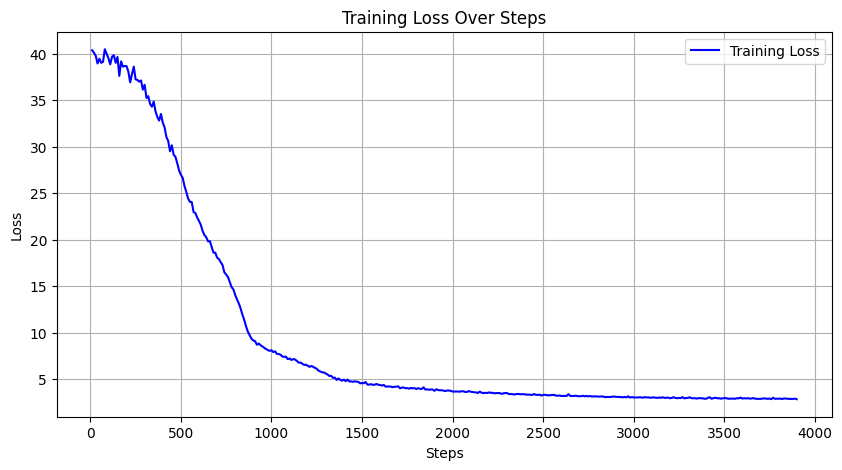

In [45]:
# 繪製訓練結果
log_history = trainer.state.log_history

# 提取步驟和損失
steps = []
losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# 繪製損失曲線
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()  # 顯示圖形

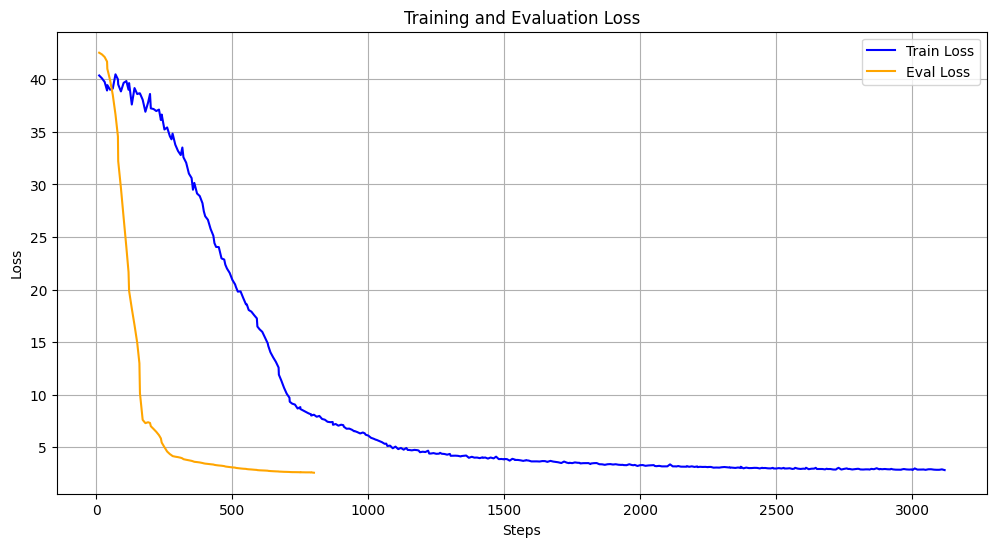

In [46]:
# 將 log_history 轉換為 DataFrame
log_history_df = pd.DataFrame(trainer.state.log_history)

# 提取訓練和驗證損失
train_losses = log_history_df['loss'].dropna().tolist()
eval_losses = log_history_df['eval_loss'].dropna().tolist()
steps = log_history_df['step'].dropna().tolist()

# 確保訓練損失和步驟匹配
train_steps = steps[:len(train_losses)]

plt.figure(figsize=(12, 6))

# 繪製訓練損失
plt.plot(train_steps, train_losses, label='Train Loss', color='blue')

# 繪製驗證損失（如果存在）
if eval_losses:
    eval_steps = steps[:len(eval_losses)]
    plt.plot(eval_steps, eval_losses, label='Eval Loss', color='orange')

plt.title('Training and Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [47]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       '../output/lora_weights', 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [48]:
peft_model.print_trainable_parameters()

trainable params: 0 || all params: 248,462,592 || trainable%: 0.0000


In [51]:
device

'mps'

In [63]:
def split_text_into_chunks(text: str, chunk_size: int = 1000, overlap: int = 100):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start = end - overlap
    return chunks

def detect_has_transaction(chunk: str):
    prompt = f"classify transaction: {chunk}"
    # 將模型移到正確的設備
    peft_model.to(device)
    
    # 確保輸入數據在正確的設備上
    inputs = tokenizer(
        prompt, 
        max_length=512, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )
    
    # 手動將輸入移到設備上
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    
    # 使用 with torch.no_grad() 來避免梯度計算
    with torch.no_grad():
        outputs = peft_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=1,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )
    
    # 將輸出移回 CPU 進行解碼
    outputs = outputs.cpu()
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

df = pd.read_csv('../input/data2.csv')
results = []
for index, row in df.iterrows():
    chunks = split_text_into_chunks(row['Chunk'])
    for chunk in chunks:
        r = detect_has_transaction(chunk)
        results.append({
            'chunk': chunk,
            'result': r==1,
            'actual': row['Actual'],
            'correct': (r==1) == (row['Actual'] == True)
        })
df2 = pd.DataFrame(results)

Total rows: 564
Number of correct rows: 472
Percentage correct: 83.69%
Number of positive: 92
Number of negative: 472
Number of positive correct: 0
Number of negative correct: 472
Positive accuracy: 0.00%
Negative accuracy: 1.00%


,chunk,result,actual,correct
0,"AEON CREDIT SERVICE (ASIA) CO., LTD. SAEON AEO...",False,False,True
1,code 商戶編號:9326) 5. PAYMENT AT CONVENIENCE STO...,False,False,True
2,code 商戶編號:9326) 5. PAYMENT AT CONVENIENCE STO...,False,False,True
3,"結單後60日仍未收到閣下之查詢,一切賬項均作實論。 Remark 備註:(P)-Princi...",False,False,True
4,"結單後60日仍未收到閣下之查詢,一切賬項均作實論。 Remark 備註:(P)-Princi...",False,True,False
...,...,...,...,...
559,ment Due | about... and you will end up paying...,False,False,True
560,our account 068-0-039716 will be debited HKD 3...,False,False,True
561,our account 068-0-039716 will be debited HKD 3...,False,False,True
562,"額 信貸安排,請填妥結單頁之表格或透過個人網上理財服務 作出指示。如有任何查詢,請致電223...",False,False,True


In [65]:
total_rows = len(df2)
correct_count = df2['correct'].value_counts()[True] if True in df2['correct'].value_counts() else 0
correct_percentage = (correct_count / total_rows) * 100
no_of_positive_correct = df2[df2['actual'] == True]['correct'].value_counts()[True] if True in df2[df2['actual'] == True]['correct'].value_counts() else 0
no_of_negative_correct = df2[df2['actual'] == False]['correct'].value_counts()[True] if True in df2[df2['actual'] == False]['correct'].value_counts() else 0
no_of_positive = df2['actual'].value_counts()[True] if True in df2['actual'].value_counts() else 0
no_of_negative = df2['actual'].value_counts()[False] if False in df2['actual'].value_counts() else 0
positive_accuracy = no_of_positive_correct / no_of_positive * 100
negative_accuracy = no_of_negative_correct / no_of_negative * 100

print(f"Total rows: {total_rows}")
print(f"Number of correct rows: {correct_count}")
print(f"Percentage correct: {correct_percentage:.2f}%")
print(f"Number of positive: {no_of_positive}")
print(f"Number of negative: {no_of_negative}")
print(f"Number of positive correct: {no_of_positive_correct}")
print(f"Number of negative correct: {no_of_negative_correct}")
print(f"Positive accuracy: {positive_accuracy:.2f}%")
print(f"Negative accuracy: {negative_accuracy:.2f}%")

display(df2)

Total rows: 564
Number of correct rows: 472
Percentage correct: 83.69%
Number of positive: 92
Number of negative: 472
Number of positive correct: 0
Number of negative correct: 472
Positive accuracy: 0.00%
Negative accuracy: 100.00%


,chunk,result,actual,correct
0,"AEON CREDIT SERVICE (ASIA) CO., LTD. SAEON AEO...",False,False,True
1,code 商戶編號:9326) 5. PAYMENT AT CONVENIENCE STO...,False,False,True
2,code 商戶編號:9326) 5. PAYMENT AT CONVENIENCE STO...,False,False,True
3,"結單後60日仍未收到閣下之查詢,一切賬項均作實論。 Remark 備註:(P)-Princi...",False,False,True
4,"結單後60日仍未收到閣下之查詢,一切賬項均作實論。 Remark 備註:(P)-Princi...",False,True,False
...,...,...,...,...
559,ment Due | about... and you will end up paying...,False,False,True
560,our account 068-0-039716 will be debited HKD 3...,False,False,True
561,our account 068-0-039716 will be debited HKD 3...,False,False,True
562,"額 信貸安排,請填妥結單頁之表格或透過個人網上理財服務 作出指示。如有任何查詢,請致電223...",False,False,True
